In [1]:
import comet_ml
import torch
from datasets import load_from_disk

/usr/local/lib/python3.11/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
tokenized_dataset = load_from_disk('/shared/Tony/MSc2024/data/tokenized_preprocessed_wikitext103.hf') #20231101
train_dataset = tokenized_dataset["train"]
val_dataset = tokenized_dataset["validation"]

In [3]:
#comet_ml.init(project_name="distilbert_dotprod")
from transformers import AutoTokenizer
import random

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
num_samples = len(train_dataset)//10
train_subset = train_dataset.select(range(num_samples))
print(train_subset)

Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 85965
})


/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import Trainer, TrainingArguments, TrainerCallback
import matplotlib.pyplot as plt
import numpy as np
from torch.optim import AdamW
from transformers import get_cosine_schedule_with_warmup

class distillTrainer(Trainer):
    def __init__(self, *args, teacher_model = None, hidden = False, **kwargs):
        super().__init__(*args,**kwargs)
        self.teacher = teacher_model
        self.teacher.eval()
        self.layer_groups = [f"transformer.layer.{i}" for i in range(6)] 
        self.current_layer_group = 0
        self.unfrozen_layers = set()
        self.layer_logs = []
        self.context_loss_stats = []
        self.hidden = hidden
        self.cosine_loss_fct = nn.CosineEmbeddingLoss(reduction="mean")
        self.param_logs = {'gamma': [], 'alpha': [], 'beta': []}

    def hidden_state_loss(self, student_outputs, teacher_outputs):
        s_hidden_states = student_outputs
        t_hidden_states = teacher_outputs
        assert t_hidden_states.size() == s_hidden_states.size()
        dim = s_hidden_states.size(-1)
        s_hidden_states_slct = s_hidden_states.view(-1, dim)
        t_hidden_states_slct = t_hidden_states.view(-1, dim)

        #target = s_hidden_states_slct.new(s_hidden_states_slct.size(0)).fill_(1) 
        #loss = self.cosine_loss_fct(s_hidden_states_slct, t_hidden_states_slct, target)
        loss = F.mse_loss(s_hidden_states_slct, t_hidden_states_slct)
        return loss
        
    def compute_loss(self, model, inputs, return_outputs = False):
        student_outputs = model(**inputs)
        student_logits = student_outputs.logits

        with torch.no_grad():
            teacher_outputs = self.teacher(**inputs)
            teacher_logits = teacher_outputs.logits

        if self.hidden:
            student_obj = student_outputs.hidden_states[self.current_layer_group + 1] # +1 because idx 0 is the embedding layer output.
            teacher_obj = teacher_outputs.hidden_states[self.current_layer_group + 1]
            loss = self.hidden_state_loss(student_obj,teacher_obj)
        else:
            student_obj = student_outputs.contexts[self.current_layer_group]
            teacher_obj = teacher_outputs.contexts[self.current_layer_group]
            loss = F.mse_loss(student_obj, teacher_obj)

        student_stats = {
            'mean': student_obj.mean().item(),
            'max': student_obj.max().item(),
            'min': student_obj.min().item()
        }
        teacher_stats = {
            'mean': teacher_obj.mean().item(),
            'max': teacher_obj.max().item(),
            'min': teacher_obj.min().item()
        }

        self.context_loss_stats.append({
            'layer': self.current_layer_group,
            'student': student_stats,
            'teacher': teacher_stats,
        })
       
        return (loss, student_outputs) if return_outputs else loss
        
    def train(self, resume_from_checkpoint=None, **kwargs):
        layer_plots = []
        for layer_group in self.layer_groups:
            print(f"Training layer group: {layer_group}")
            self.switch_to_next_layer_group()
            print(self.get_num_trainable_parameters())
            res = super().train(resume_from_checkpoint=resume_from_checkpoint, **kwargs)
            self.layer_logs.append(self.state.log_history.copy())
            self.current_layer_group += 1
            #self.save_model(f"./results/layer_{layer_group}")
        self.plot_layer_losses()
        return res

    def freeze_all_layers(self):
        for param in self.model.parameters():
            param.requires_grad = False
    
    def switch_to_next_layer_group(self):
        self.freeze_all_layers()
        print("Current layer", self.current_layer_group)
        
        if self.current_layer_group < len(self.layer_groups):
            current_layer = self.layer_groups[self.current_layer_group]
            newly_unfrozen_params = []
            
            for name, param in self.model.named_parameters():
                if current_layer in name and any(qkv in name for qkv in ['q_lin', 'k_lin', 'v_lin','alpha', 'beta', 'gamma']): #v_lin q_lin k_lin
                    param.requires_grad = True
                    newly_unfrozen_params.append(param)
                        
            print(f"Unfrozen parameters for layer {self.current_layer_group}:")
            for name, param in self.model.named_parameters():
                if param.requires_grad:
                    print(f"  - {name}")

            optimizer_grouped_parameters = [
            {
                "params": [p for p in newly_unfrozen_params if p.requires_grad],
                "weight_decay": self.args.weight_decay,
            }
            ]
            
            self.optimizer = AdamW(optimizer_grouped_parameters, lr=self.args.learning_rate)
            
            num_training_steps = len(self.train_dataset) // self.args.train_batch_size * self.args.num_train_epochs
            warmup_rate = 0.05  # 10% 
            warmup_steps = int(num_training_steps * warmup_rate)
            self.lr_scheduler = get_cosine_schedule_with_warmup(
                self.optimizer,
                num_warmup_steps=warmup_steps, 
                num_training_steps=num_training_steps
            )

    def plot_layer_losses(self):
        fig, axs = plt.subplots(2, 3, figsize=(20, 15))
        for layer, (ax, layer_logs) in enumerate(zip(axs.flatten(), self.layer_logs)):
            train_data = [(log['step'], log['loss']) for log in layer_logs if 'loss' in log]
            eval_data = [(log['step'], log['eval_loss']) for log in layer_logs if 'eval_loss' in log]
            
            if train_data:
                steps, losses = zip(*train_data)
                ax.plot(steps, losses, label='Train Loss')
            if eval_data:
                steps, losses = zip(*eval_data)
                ax.plot(steps, losses, label='Validation Loss')
            
            ax.set_title(f'Layer {layer} Loss')
            ax.set_xlabel('Steps')
            ax.set_ylabel('Loss')
            ax.legend()
        
        plt.tight_layout()
        plt.savefig('context_center_layerloss.png')
        plt.close()






    

2024-09-25 22:43:32.058046: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-25 22:43:32.070219: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-25 22:43:32.083200: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-25 22:43:32.087079: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-25 22:43:32.097905: I tensorflow/core/platform/cpu_feature_guar

In [5]:
from transformers import DistilBertForSequenceClassification, AutoModelForSequenceClassification, DistilBertConfig, DistilBertForMaskedLM, DataCollatorForLanguageModeling
from iDistilbert import iDistilBertForMaskedLM
from transformers import AutoTokenizer

student_id = "distilbert/distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(student_id)
#Load Models

teacher_id = "distilbert/distilbert-base-uncased"
teacher_config = DistilBertConfig(    
    distance_metric = "cosine_distance",
    activation_function = "softmax",
    signed_inhibitor =  False,
    alpha = 0,
    center = False,
    output_contexts = True,
    output_hidden_states = False,
)
    
teacher_model = iDistilBertForMaskedLM.from_pretrained(
        teacher_id,
        config=teacher_config,
    )

student_config = DistilBertConfig(
    distance_metric = "manhattan_distance",
    activation_function = "relu",
    signed_inhibitor =  True,
    #alpha = 0,
    center = True,
    output_contexts = True,
    output_hidden_states = False,
    )

student_model = iDistilBertForMaskedLM(student_config)

initialized_weights = torch.load('/shared/Tony/MSc2024/distilbert_init/models/distilbert_qkv.pth')
student_model.load_state_dict(initialized_weights, strict=False)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
teacher_model.to(device)
student_model.to(device)

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of iDistilBertForMaskedLM were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['distilbert.transformer.layer.0.attention.alpha', 'distilbert.transformer.layer.0.attention.beta', 'distilbert.transformer.layer.0.attention.gamma', 'distilbert.transformer.layer.1.attention.alpha', 'distilbert.transformer.layer.1.attention.beta', 'distilbert.transformer.layer.1.attention.gamma', 'distilbert.transformer.layer.2.attention.alpha', 'distilbert.transformer.layer.2.attention.beta', 'distilbert.transformer.layer.2.attention.gamma', 'distilbert

iDistilBertForMaskedLM(
  (activation): GELUActivation()
  (distilbert): iDistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): iTransformer(
      (layer): ModuleList(
        (0-5): 6 x iTransformerBlock(
          (attention): iMultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout

In [6]:
EPOCHS = 2
BATCH_SIZE = 8
LEARNING_RATE = 5e-4
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=True, mlm_probability=0.15)

training_args = TrainingArguments(
    output_dir = './results',
    num_train_epochs = EPOCHS,
    per_device_train_batch_size = BATCH_SIZE,
    per_device_eval_batch_size = BATCH_SIZE,
    learning_rate = LEARNING_RATE,
    logging_dir = './logs',
    load_best_model_at_end= True,
    metric_for_best_model="loss",
    eval_strategy="steps",
    save_strategy="steps",
    eval_steps = 268, 
    logging_steps = 20,
    save_steps=268,
    save_total_limit=2,
    seed = 42,
    #report_to=['comet_ml', 'tensorboard'],
    report_to=['tensorboard'],
    warmup_ratio=0.05,
    gradient_accumulation_steps=4,
    lr_scheduler_type="cosine",
)

trainer = distillTrainer(
    teacher_model=teacher_model,
    model=student_model,                         
    args=training_args,                  
    train_dataset=train_subset,         
    eval_dataset=val_dataset,
    tokenizer = tokenizer,
    data_collator = data_collator,
    hidden = False,
)


Training layer group: transformer.layer.0
Current layer 0
Unfrozen parameters for layer 0:
  - distilbert.transformer.layer.0.attention.alpha
  - distilbert.transformer.layer.0.attention.beta
  - distilbert.transformer.layer.0.attention.gamma
  - distilbert.transformer.layer.0.attention.q_lin.weight
  - distilbert.transformer.layer.0.attention.q_lin.bias
  - distilbert.transformer.layer.0.attention.k_lin.weight
  - distilbert.transformer.layer.0.attention.k_lin.bias
  - distilbert.transformer.layer.0.attention.v_lin.weight
  - distilbert.transformer.layer.0.attention.v_lin.bias
1771779


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Logged parameters for layer 0:
  - gamma: 1.0
  - alpha: 0.5
  - beta: 1.0
Logged parameters for layer 0:
  - gamma: 1.0
  - alpha: 0.5
  - beta: 1.0
Logged parameters for layer 0:
  - gamma: 1.0
  - alpha: 0.5
  - beta: 1.0
Logged parameters for layer 0:
  - gamma: 1.0
  - alpha: 0.5
  - beta: 1.0


Step,Training Loss,Validation Loss
268,0.188100,0.128672
536,0.098800,0.097396
804,0.081500,0.083358
1072,0.073600,0.079409
1340,0.068600,0.068057
1608,0.062000,0.064208
1876,0.059800,0.059124
2144,0.055900,0.056233
2412,0.055300,0.055034
2680,0.053300,0.053438


Logged parameters for layer 0:
  - gamma: 0.9696036577224731
  - alpha: 0.5282542705535889
  - beta: 0.975882351398468
Logged parameters for layer 0:
  - gamma: 0.9696036577224731
  - alpha: 0.5282542705535889
  - beta: 0.975882351398468
Logged parameters for layer 0:
  - gamma: 0.9696036577224731
  - alpha: 0.5282542705535889
  - beta: 0.975882351398468
Logged parameters for layer 0:
  - gamma: 0.9696036577224731
  - alpha: 0.5282542705535889
  - beta: 0.975882351398468
Logged parameters for layer 0:
  - gamma: 0.9696036577224731
  - alpha: 0.5282542705535889
  - beta: 0.975882351398468
Logged parameters for layer 0:
  - gamma: 0.9696036577224731
  - alpha: 0.5282542705535889
  - beta: 0.975882351398468
Logged parameters for layer 0:
  - gamma: 0.9696036577224731
  - alpha: 0.5282542705535889
  - beta: 0.975882351398468
Logged parameters for layer 0:
  - gamma: 0.9696036577224731
  - alpha: 0.5282542705535889
  - beta: 0.975882351398468
Logged parameters for layer 0:
  - gamma: 0.9696

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Logged parameters for layer 0:
  - gamma: 0.9696036577224731
  - alpha: 0.5282542705535889
  - beta: 0.975882351398468
Logged parameters for layer 0:
  - gamma: 0.9696036577224731
  - alpha: 0.5282542705535889
  - beta: 0.975882351398468
Logged parameters for layer 0:
  - gamma: 0.9696036577224731
  - alpha: 0.5282542705535889
  - beta: 0.975882351398468
Logged parameters for layer 0:
  - gamma: 0.9696036577224731
  - alpha: 0.5282542705535889
  - beta: 0.975882351398468
Logged parameters for layer 0:
  - gamma: 0.9224249720573425
  - alpha: 0.5622656941413879
  - beta: 0.9436087012290955
Logged parameters for layer 0:
  - gamma: 0.9224249720573425
  - alpha: 0.5622656941413879
  - beta: 0.9436087012290955
Logged parameters for layer 0:
  - gamma: 0.9224249720573425
  - alpha: 0.5622656941413879
  - beta: 0.9436087012290955
Logged parameters for layer 0:
  - gamma: 0.9224249720573425
  - alpha: 0.5622656941413879
  - beta: 0.9436087012290955
Logged parameters for layer 0:
  - gamma: 0.

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Logged parameters for layer 0:
  - gamma: 0.9224249720573425
  - alpha: 0.5622656941413879
  - beta: 0.9436087012290955
Logged parameters for layer 0:
  - gamma: 0.9224249720573425
  - alpha: 0.5622656941413879
  - beta: 0.9436087012290955
Logged parameters for layer 0:
  - gamma: 0.9224249720573425
  - alpha: 0.5622656941413879
  - beta: 0.9436087012290955
Logged parameters for layer 0:
  - gamma: 0.9224249720573425
  - alpha: 0.5622656941413879
  - beta: 0.9436087012290955
Logged parameters for layer 0:
  - gamma: 0.868952214717865
  - alpha: 0.5914941430091858
  - beta: 0.9238170981407166
Logged parameters for layer 0:
  - gamma: 0.868952214717865
  - alpha: 0.5914941430091858
  - beta: 0.9238170981407166
Logged parameters for layer 0:
  - gamma: 0.868952214717865
  - alpha: 0.5914941430091858
  - beta: 0.9238170981407166
Logged parameters for layer 0:
  - gamma: 0.868952214717865
  - alpha: 0.5914941430091858
  - beta: 0.9238170981407166
Logged parameters for layer 0:
  - gamma: 0.

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Logged parameters for layer 0:
  - gamma: 0.868952214717865
  - alpha: 0.5914941430091858
  - beta: 0.9238170981407166
Logged parameters for layer 0:
  - gamma: 0.868952214717865
  - alpha: 0.5914941430091858
  - beta: 0.9238170981407166
Logged parameters for layer 0:
  - gamma: 0.868952214717865
  - alpha: 0.5914941430091858
  - beta: 0.9238170981407166
Logged parameters for layer 0:
  - gamma: 0.868952214717865
  - alpha: 0.5914941430091858
  - beta: 0.9238170981407166
Logged parameters for layer 0:
  - gamma: 0.8347708582878113
  - alpha: 0.606194257736206
  - beta: 0.9100931882858276
Logged parameters for layer 0:
  - gamma: 0.8347708582878113
  - alpha: 0.606194257736206
  - beta: 0.9100931882858276
Logged parameters for layer 0:
  - gamma: 0.8347708582878113
  - alpha: 0.606194257736206
  - beta: 0.9100931882858276
Logged parameters for layer 0:
  - gamma: 0.8347708582878113
  - alpha: 0.606194257736206
  - beta: 0.9100931882858276
Logged parameters for layer 0:
  - gamma: 0.8347

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Logged parameters for layer 0:
  - gamma: 0.8347708582878113
  - alpha: 0.606194257736206
  - beta: 0.9100931882858276
Logged parameters for layer 0:
  - gamma: 0.8347708582878113
  - alpha: 0.606194257736206
  - beta: 0.9100931882858276
Logged parameters for layer 0:
  - gamma: 0.8347708582878113
  - alpha: 0.606194257736206
  - beta: 0.9100931882858276
Logged parameters for layer 0:
  - gamma: 0.8347708582878113
  - alpha: 0.606194257736206
  - beta: 0.9100931882858276
Logged parameters for layer 0:
  - gamma: 0.804735004901886
  - alpha: 0.6165441870689392
  - beta: 0.8961158990859985
Logged parameters for layer 0:
  - gamma: 0.804735004901886
  - alpha: 0.6165441870689392
  - beta: 0.8961158990859985
Logged parameters for layer 0:
  - gamma: 0.804735004901886
  - alpha: 0.6165441870689392
  - beta: 0.8961158990859985
Logged parameters for layer 0:
  - gamma: 0.804735004901886
  - alpha: 0.6165441870689392
  - beta: 0.8961158990859985
Logged parameters for layer 0:
  - gamma: 0.8047

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Logged parameters for layer 0:
  - gamma: 0.804735004901886
  - alpha: 0.6165441870689392
  - beta: 0.8961158990859985
Logged parameters for layer 0:
  - gamma: 0.804735004901886
  - alpha: 0.6165441870689392
  - beta: 0.8961158990859985
Logged parameters for layer 0:
  - gamma: 0.804735004901886
  - alpha: 0.6165441870689392
  - beta: 0.8961158990859985
Logged parameters for layer 0:
  - gamma: 0.7804855108261108
  - alpha: 0.6244632601737976
  - beta: 0.8825483322143555
Logged parameters for layer 0:
  - gamma: 0.7804855108261108
  - alpha: 0.6244632601737976
  - beta: 0.8825483322143555
Logged parameters for layer 0:
  - gamma: 0.7804855108261108
  - alpha: 0.6244632601737976
  - beta: 0.8825483322143555
Logged parameters for layer 0:
  - gamma: 0.7804855108261108
  - alpha: 0.6244632601737976
  - beta: 0.8825483322143555
Logged parameters for layer 0:
  - gamma: 0.7804855108261108
  - alpha: 0.6244632601737976
  - beta: 0.8825483322143555
Logged parameters for layer 0:
  - gamma: 0

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Logged parameters for layer 0:
  - gamma: 0.7804855108261108
  - alpha: 0.6244632601737976
  - beta: 0.8825483322143555
Logged parameters for layer 0:
  - gamma: 0.7804855108261108
  - alpha: 0.6244632601737976
  - beta: 0.8825483322143555
Logged parameters for layer 0:
  - gamma: 0.7804855108261108
  - alpha: 0.6244632601737976
  - beta: 0.8825483322143555
Logged parameters for layer 0:
  - gamma: 0.7804855108261108
  - alpha: 0.6244632601737976
  - beta: 0.8825483322143555
Logged parameters for layer 0:
  - gamma: 0.7576043009757996
  - alpha: 0.6316187381744385
  - beta: 0.8690841197967529
Logged parameters for layer 0:
  - gamma: 0.7576043009757996
  - alpha: 0.6316187381744385
  - beta: 0.8690841197967529
Logged parameters for layer 0:
  - gamma: 0.7576043009757996
  - alpha: 0.6316187381744385
  - beta: 0.8690841197967529
Logged parameters for layer 0:
  - gamma: 0.7576043009757996
  - alpha: 0.6316187381744385
  - beta: 0.8690841197967529
Logged parameters for layer 0:
  - gamma

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Logged parameters for layer 0:
  - gamma: 0.7576043009757996
  - alpha: 0.6316187381744385
  - beta: 0.8690841197967529
Logged parameters for layer 0:
  - gamma: 0.7576043009757996
  - alpha: 0.6316187381744385
  - beta: 0.8690841197967529
Logged parameters for layer 0:
  - gamma: 0.7576043009757996
  - alpha: 0.6316187381744385
  - beta: 0.8690841197967529
Logged parameters for layer 0:
  - gamma: 0.7576043009757996
  - alpha: 0.6316187381744385
  - beta: 0.8690841197967529
Logged parameters for layer 0:
  - gamma: 0.7362561821937561
  - alpha: 0.6375621557235718
  - beta: 0.8563164472579956
Logged parameters for layer 0:
  - gamma: 0.7362561821937561
  - alpha: 0.6375621557235718
  - beta: 0.8563164472579956
Logged parameters for layer 0:
  - gamma: 0.7362561821937561
  - alpha: 0.6375621557235718
  - beta: 0.8563164472579956
Logged parameters for layer 0:
  - gamma: 0.7362561821937561
  - alpha: 0.6375621557235718
  - beta: 0.8563164472579956
Logged parameters for layer 0:
  - gamma

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Logged parameters for layer 0:
  - gamma: 0.7362561821937561
  - alpha: 0.6375621557235718
  - beta: 0.8563164472579956
Logged parameters for layer 0:
  - gamma: 0.7362561821937561
  - alpha: 0.6375621557235718
  - beta: 0.8563164472579956
Logged parameters for layer 0:
  - gamma: 0.7362561821937561
  - alpha: 0.6375621557235718
  - beta: 0.8563164472579956
Logged parameters for layer 0:
  - gamma: 0.7362561821937561
  - alpha: 0.6375621557235718
  - beta: 0.8563164472579956
Logged parameters for layer 0:
  - gamma: 0.7155596017837524
  - alpha: 0.6427619457244873
  - beta: 0.8440706729888916
Logged parameters for layer 0:
  - gamma: 0.7155596017837524
  - alpha: 0.6427619457244873
  - beta: 0.8440706729888916
Logged parameters for layer 0:
  - gamma: 0.7155596017837524
  - alpha: 0.6427619457244873
  - beta: 0.8440706729888916
Logged parameters for layer 0:
  - gamma: 0.7155596017837524
  - alpha: 0.6427619457244873
  - beta: 0.8440706729888916
Logged parameters for layer 0:
  - gamma

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Logged parameters for layer 0:
  - gamma: 0.7155596017837524
  - alpha: 0.6427619457244873
  - beta: 0.8440706729888916
Logged parameters for layer 0:
  - gamma: 0.7155596017837524
  - alpha: 0.6427619457244873
  - beta: 0.8440706729888916
Logged parameters for layer 0:
  - gamma: 0.7155596017837524
  - alpha: 0.6427619457244873
  - beta: 0.8440706729888916
Logged parameters for layer 0:
  - gamma: 0.7155596017837524
  - alpha: 0.6427619457244873
  - beta: 0.8440706729888916
Logged parameters for layer 0:
  - gamma: 0.6954798698425293
  - alpha: 0.6472959518432617
  - beta: 0.8314658999443054
Logged parameters for layer 0:
  - gamma: 0.6954798698425293
  - alpha: 0.6472959518432617
  - beta: 0.8314658999443054
Logged parameters for layer 0:
  - gamma: 0.6954798698425293
  - alpha: 0.6472959518432617
  - beta: 0.8314658999443054
Logged parameters for layer 0:
  - gamma: 0.6954798698425293
  - alpha: 0.6472959518432617
  - beta: 0.8314658999443054
Logged parameters for layer 0:
  - gamma

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Logged parameters for layer 0:
  - gamma: 0.6954798698425293
  - alpha: 0.6472959518432617
  - beta: 0.8314658999443054
Logged parameters for layer 0:
  - gamma: 0.6954798698425293
  - alpha: 0.6472959518432617
  - beta: 0.8314658999443054
Logged parameters for layer 0:
  - gamma: 0.6954798698425293
  - alpha: 0.6472959518432617
  - beta: 0.8314658999443054
Logged parameters for layer 0:
  - gamma: 0.6954798698425293
  - alpha: 0.6472959518432617
  - beta: 0.8314658999443054


There were missing keys in the checkpoint model loaded: ['vocab_projector.weight'].


Training layer group: transformer.layer.1
Current layer 1
Unfrozen parameters for layer 1:
  - distilbert.transformer.layer.1.attention.alpha
  - distilbert.transformer.layer.1.attention.beta
  - distilbert.transformer.layer.1.attention.gamma
  - distilbert.transformer.layer.1.attention.q_lin.weight
  - distilbert.transformer.layer.1.attention.q_lin.bias
  - distilbert.transformer.layer.1.attention.k_lin.weight
  - distilbert.transformer.layer.1.attention.k_lin.bias
  - distilbert.transformer.layer.1.attention.v_lin.weight
  - distilbert.transformer.layer.1.attention.v_lin.bias
1771779
Logged parameters for layer 1:
  - gamma: 1.0
  - alpha: 0.5
  - beta: 1.0


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Logged parameters for layer 1:
  - gamma: 1.0
  - alpha: 0.5
  - beta: 1.0
Logged parameters for layer 1:
  - gamma: 1.0
  - alpha: 0.5
  - beta: 1.0
Logged parameters for layer 1:
  - gamma: 1.0
  - alpha: 0.5
  - beta: 1.0


Step,Training Loss,Validation Loss
268,0.121500,0.113715
536,0.093300,0.094747
804,0.090900,0.087481
1072,0.078300,0.077848
1340,0.072600,0.071913
1608,0.067500,0.066359
1876,0.064900,0.061390
2144,0.062400,0.059970
2412,0.061500,0.058596
2680,0.059600,0.057855


Logged parameters for layer 1:
  - gamma: 0.9716195464134216
  - alpha: 0.5269420146942139
  - beta: 0.9786049127578735
Logged parameters for layer 1:
  - gamma: 0.9716195464134216
  - alpha: 0.5269420146942139
  - beta: 0.9786049127578735
Logged parameters for layer 1:
  - gamma: 0.9716195464134216
  - alpha: 0.5269420146942139
  - beta: 0.9786049127578735
Logged parameters for layer 1:
  - gamma: 0.9716195464134216
  - alpha: 0.5269420146942139
  - beta: 0.9786049127578735
Logged parameters for layer 1:
  - gamma: 0.9716195464134216
  - alpha: 0.5269420146942139
  - beta: 0.9786049127578735
Logged parameters for layer 1:
  - gamma: 0.9716195464134216
  - alpha: 0.5269420146942139
  - beta: 0.9786049127578735
Logged parameters for layer 1:
  - gamma: 0.9716195464134216
  - alpha: 0.5269420146942139
  - beta: 0.9786049127578735
Logged parameters for layer 1:
  - gamma: 0.9716195464134216
  - alpha: 0.5269420146942139
  - beta: 0.9786049127578735
Logged parameters for layer 1:
  - gamma

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Logged parameters for layer 1:
  - gamma: 0.9716195464134216
  - alpha: 0.5269420146942139
  - beta: 0.9786049127578735
Logged parameters for layer 1:
  - gamma: 0.9716195464134216
  - alpha: 0.5269420146942139
  - beta: 0.9786049127578735
Logged parameters for layer 1:
  - gamma: 0.9716195464134216
  - alpha: 0.5269420146942139
  - beta: 0.9786049127578735
Logged parameters for layer 1:
  - gamma: 0.9716195464134216
  - alpha: 0.5269420146942139
  - beta: 0.9786049127578735
Logged parameters for layer 1:
  - gamma: 0.9563164114952087
  - alpha: 0.5410688519477844
  - beta: 0.9696755409240723
Logged parameters for layer 1:
  - gamma: 0.9563164114952087
  - alpha: 0.5410688519477844
  - beta: 0.9696755409240723
Logged parameters for layer 1:
  - gamma: 0.9563164114952087
  - alpha: 0.5410688519477844
  - beta: 0.9696755409240723
Logged parameters for layer 1:
  - gamma: 0.9563164114952087
  - alpha: 0.5410688519477844
  - beta: 0.9696755409240723
Logged parameters for layer 1:
  - gamma

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Logged parameters for layer 1:
  - gamma: 0.9563164114952087
  - alpha: 0.5410688519477844
  - beta: 0.9696755409240723
Logged parameters for layer 1:
  - gamma: 0.9563164114952087
  - alpha: 0.5410688519477844
  - beta: 0.9696755409240723
Logged parameters for layer 1:
  - gamma: 0.9563164114952087
  - alpha: 0.5410688519477844
  - beta: 0.9696755409240723
Logged parameters for layer 1:
  - gamma: 0.9563164114952087
  - alpha: 0.5410688519477844
  - beta: 0.9696755409240723
Logged parameters for layer 1:
  - gamma: 0.9372754693031311
  - alpha: 0.5524044036865234
  - beta: 0.9585627317428589
Logged parameters for layer 1:
  - gamma: 0.9372754693031311
  - alpha: 0.5524044036865234
  - beta: 0.9585627317428589
Logged parameters for layer 1:
  - gamma: 0.9372754693031311
  - alpha: 0.5524044036865234
  - beta: 0.9585627317428589
Logged parameters for layer 1:
  - gamma: 0.9372754693031311
  - alpha: 0.5524044036865234
  - beta: 0.9585627317428589
Logged parameters for layer 1:
  - gamma

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Logged parameters for layer 1:
  - gamma: 0.9372754693031311
  - alpha: 0.5524044036865234
  - beta: 0.9585627317428589
Logged parameters for layer 1:
  - gamma: 0.9372754693031311
  - alpha: 0.5524044036865234
  - beta: 0.9585627317428589
Logged parameters for layer 1:
  - gamma: 0.9372754693031311
  - alpha: 0.5524044036865234
  - beta: 0.9585627317428589
Logged parameters for layer 1:
  - gamma: 0.9372754693031311
  - alpha: 0.5524044036865234
  - beta: 0.9585627317428589
Logged parameters for layer 1:
  - gamma: 0.9244318008422852
  - alpha: 0.558448314666748
  - beta: 0.9476667642593384
Logged parameters for layer 1:
  - gamma: 0.9244318008422852
  - alpha: 0.558448314666748
  - beta: 0.9476667642593384
Logged parameters for layer 1:
  - gamma: 0.9244318008422852
  - alpha: 0.558448314666748
  - beta: 0.9476667642593384
Logged parameters for layer 1:
  - gamma: 0.9244318008422852
  - alpha: 0.558448314666748
  - beta: 0.9476667642593384
Logged parameters for layer 1:
  - gamma: 0.

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Logged parameters for layer 1:
  - gamma: 0.9244318008422852
  - alpha: 0.558448314666748
  - beta: 0.9476667642593384
Logged parameters for layer 1:
  - gamma: 0.9244318008422852
  - alpha: 0.558448314666748
  - beta: 0.9476667642593384
Logged parameters for layer 1:
  - gamma: 0.9244318008422852
  - alpha: 0.558448314666748
  - beta: 0.9476667642593384
Logged parameters for layer 1:
  - gamma: 0.9244318008422852
  - alpha: 0.558448314666748
  - beta: 0.9476667642593384
Logged parameters for layer 1:
  - gamma: 0.9114153385162354
  - alpha: 0.5642999410629272
  - beta: 0.9370161890983582
Logged parameters for layer 1:
  - gamma: 0.9114153385162354
  - alpha: 0.5642999410629272
  - beta: 0.9370161890983582
Logged parameters for layer 1:
  - gamma: 0.9114153385162354
  - alpha: 0.5642999410629272
  - beta: 0.9370161890983582
Logged parameters for layer 1:
  - gamma: 0.9114153385162354
  - alpha: 0.5642999410629272
  - beta: 0.9370161890983582
Logged parameters for layer 1:
  - gamma: 0.

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Logged parameters for layer 1:
  - gamma: 0.9114153385162354
  - alpha: 0.5642999410629272
  - beta: 0.9370161890983582
Logged parameters for layer 1:
  - gamma: 0.9114153385162354
  - alpha: 0.5642999410629272
  - beta: 0.9370161890983582
Logged parameters for layer 1:
  - gamma: 0.9114153385162354
  - alpha: 0.5642999410629272
  - beta: 0.9370161890983582
Logged parameters for layer 1:
  - gamma: 0.9114153385162354
  - alpha: 0.5642999410629272
  - beta: 0.9370161890983582
Logged parameters for layer 1:
  - gamma: 0.894413948059082
  - alpha: 0.5724931955337524
  - beta: 0.9282420873641968
Logged parameters for layer 1:
  - gamma: 0.894413948059082
  - alpha: 0.5724931955337524
  - beta: 0.9282420873641968
Logged parameters for layer 1:
  - gamma: 0.894413948059082
  - alpha: 0.5724931955337524
  - beta: 0.9282420873641968
Logged parameters for layer 1:
  - gamma: 0.894413948059082
  - alpha: 0.5724931955337524
  - beta: 0.9282420873641968
Logged parameters for layer 1:
  - gamma: 0.

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Logged parameters for layer 1:
  - gamma: 0.894413948059082
  - alpha: 0.5724931955337524
  - beta: 0.9282420873641968
Logged parameters for layer 1:
  - gamma: 0.894413948059082
  - alpha: 0.5724931955337524
  - beta: 0.9282420873641968
Logged parameters for layer 1:
  - gamma: 0.894413948059082
  - alpha: 0.5724931955337524
  - beta: 0.9282420873641968
Logged parameters for layer 1:
  - gamma: 0.894413948059082
  - alpha: 0.5724931955337524
  - beta: 0.9282420873641968
Logged parameters for layer 1:
  - gamma: 0.877163290977478
  - alpha: 0.5812371969223022
  - beta: 0.9232737421989441
Logged parameters for layer 1:
  - gamma: 0.877163290977478
  - alpha: 0.5812371969223022
  - beta: 0.9232737421989441
Logged parameters for layer 1:
  - gamma: 0.877163290977478
  - alpha: 0.5812371969223022
  - beta: 0.9232737421989441
Logged parameters for layer 1:
  - gamma: 0.877163290977478
  - alpha: 0.5812371969223022
  - beta: 0.9232737421989441
Logged parameters for layer 1:
  - gamma: 0.8771

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Logged parameters for layer 1:
  - gamma: 0.877163290977478
  - alpha: 0.5812371969223022
  - beta: 0.9232737421989441
Logged parameters for layer 1:
  - gamma: 0.877163290977478
  - alpha: 0.5812371969223022
  - beta: 0.9232737421989441
Logged parameters for layer 1:
  - gamma: 0.877163290977478
  - alpha: 0.5812371969223022
  - beta: 0.9232737421989441
Logged parameters for layer 1:
  - gamma: 0.877163290977478
  - alpha: 0.5812371969223022
  - beta: 0.9232737421989441
Logged parameters for layer 1:
  - gamma: 0.8616923689842224
  - alpha: 0.5900010466575623
  - beta: 0.9217893481254578
Logged parameters for layer 1:
  - gamma: 0.8616923689842224
  - alpha: 0.5900010466575623
  - beta: 0.9217893481254578
Logged parameters for layer 1:
  - gamma: 0.8616923689842224
  - alpha: 0.5900010466575623
  - beta: 0.9217893481254578
Logged parameters for layer 1:
  - gamma: 0.8616923689842224
  - alpha: 0.5900010466575623
  - beta: 0.9217893481254578
Logged parameters for layer 1:
  - gamma: 0.

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Logged parameters for layer 1:
  - gamma: 0.8616923689842224
  - alpha: 0.5900010466575623
  - beta: 0.9217893481254578
Logged parameters for layer 1:
  - gamma: 0.8616923689842224
  - alpha: 0.5900010466575623
  - beta: 0.9217893481254578
Logged parameters for layer 1:
  - gamma: 0.8616923689842224
  - alpha: 0.5900010466575623
  - beta: 0.9217893481254578
Logged parameters for layer 1:
  - gamma: 0.8616923689842224
  - alpha: 0.5900010466575623
  - beta: 0.9217893481254578
Logged parameters for layer 1:
  - gamma: 0.8448866009712219
  - alpha: 0.5998106002807617
  - beta: 0.9217807650566101
Logged parameters for layer 1:
  - gamma: 0.8448866009712219
  - alpha: 0.5998106002807617
  - beta: 0.9217807650566101
Logged parameters for layer 1:
  - gamma: 0.8448866009712219
  - alpha: 0.5998106002807617
  - beta: 0.9217807650566101
Logged parameters for layer 1:
  - gamma: 0.8448866009712219
  - alpha: 0.5998106002807617
  - beta: 0.9217807650566101
Logged parameters for layer 1:
  - gamma

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Logged parameters for layer 1:
  - gamma: 0.8448866009712219
  - alpha: 0.5998106002807617
  - beta: 0.9217807650566101
Logged parameters for layer 1:
  - gamma: 0.8448866009712219
  - alpha: 0.5998106002807617
  - beta: 0.9217807650566101
Logged parameters for layer 1:
  - gamma: 0.8448866009712219
  - alpha: 0.5998106002807617
  - beta: 0.9217807650566101
Logged parameters for layer 1:
  - gamma: 0.8448866009712219
  - alpha: 0.5998106002807617
  - beta: 0.9217807650566101
Logged parameters for layer 1:
  - gamma: 0.8292111754417419
  - alpha: 0.6094979047775269
  - beta: 0.9228200316429138
Logged parameters for layer 1:
  - gamma: 0.8292111754417419
  - alpha: 0.6094979047775269
  - beta: 0.9228200316429138
Logged parameters for layer 1:
  - gamma: 0.8292111754417419
  - alpha: 0.6094979047775269
  - beta: 0.9228200316429138
Logged parameters for layer 1:
  - gamma: 0.8292111754417419
  - alpha: 0.6094979047775269
  - beta: 0.9228200316429138
Logged parameters for layer 1:
  - gamma

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Logged parameters for layer 1:
  - gamma: 0.8292111754417419
  - alpha: 0.6094979047775269
  - beta: 0.9228200316429138
Logged parameters for layer 1:
  - gamma: 0.8292111754417419
  - alpha: 0.6094979047775269
  - beta: 0.9228200316429138
Logged parameters for layer 1:
  - gamma: 0.8292111754417419
  - alpha: 0.6094979047775269
  - beta: 0.9228200316429138
Logged parameters for layer 1:
  - gamma: 0.8292111754417419
  - alpha: 0.6094979047775269
  - beta: 0.9228200316429138


There were missing keys in the checkpoint model loaded: ['vocab_projector.weight'].


Training layer group: transformer.layer.2
Current layer 2
Unfrozen parameters for layer 2:
  - distilbert.transformer.layer.2.attention.alpha
  - distilbert.transformer.layer.2.attention.beta
  - distilbert.transformer.layer.2.attention.gamma
  - distilbert.transformer.layer.2.attention.q_lin.weight
  - distilbert.transformer.layer.2.attention.q_lin.bias
  - distilbert.transformer.layer.2.attention.k_lin.weight
  - distilbert.transformer.layer.2.attention.k_lin.bias
  - distilbert.transformer.layer.2.attention.v_lin.weight
  - distilbert.transformer.layer.2.attention.v_lin.bias
1771779


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Logged parameters for layer 2:
  - gamma: 1.0
  - alpha: 0.5
  - beta: 1.0
Logged parameters for layer 2:
  - gamma: 1.0
  - alpha: 0.5
  - beta: 1.0
Logged parameters for layer 2:
  - gamma: 1.0
  - alpha: 0.5
  - beta: 1.0
Logged parameters for layer 2:
  - gamma: 1.0
  - alpha: 0.5
  - beta: 1.0


Step,Training Loss,Validation Loss
268,0.112700,0.096755
536,0.082200,0.081132
804,0.077600,0.077895
1072,0.075400,0.075315
1340,0.074600,0.073834
1608,0.072500,0.072222
1876,0.068600,0.066461
2144,0.066100,0.065832
2412,0.065300,0.063094
2680,0.064500,0.062059


Logged parameters for layer 2:
  - gamma: 0.9702351689338684
  - alpha: 0.5301551818847656
  - beta: 0.9769783616065979
Logged parameters for layer 2:
  - gamma: 0.9702351689338684
  - alpha: 0.5301551818847656
  - beta: 0.9769783616065979
Logged parameters for layer 2:
  - gamma: 0.9702351689338684
  - alpha: 0.5301551818847656
  - beta: 0.9769783616065979
Logged parameters for layer 2:
  - gamma: 0.9702351689338684
  - alpha: 0.5301551818847656
  - beta: 0.9769783616065979
Logged parameters for layer 2:
  - gamma: 0.9702351689338684
  - alpha: 0.5301551818847656
  - beta: 0.9769783616065979
Logged parameters for layer 2:
  - gamma: 0.9702351689338684
  - alpha: 0.5301551818847656
  - beta: 0.9769783616065979
Logged parameters for layer 2:
  - gamma: 0.9702351689338684
  - alpha: 0.5301551818847656
  - beta: 0.9769783616065979
Logged parameters for layer 2:
  - gamma: 0.9702351689338684
  - alpha: 0.5301551818847656
  - beta: 0.9769783616065979
Logged parameters for layer 2:
  - gamma

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Logged parameters for layer 2:
  - gamma: 0.9702351689338684
  - alpha: 0.5301551818847656
  - beta: 0.9769783616065979
Logged parameters for layer 2:
  - gamma: 0.9702351689338684
  - alpha: 0.5301551818847656
  - beta: 0.9769783616065979
Logged parameters for layer 2:
  - gamma: 0.9702351689338684
  - alpha: 0.5301551818847656
  - beta: 0.9769783616065979
Logged parameters for layer 2:
  - gamma: 0.9702351689338684
  - alpha: 0.5301551818847656
  - beta: 0.9769783616065979
Logged parameters for layer 2:
  - gamma: 0.9598425030708313
  - alpha: 0.5439085960388184
  - beta: 0.9696828722953796
Logged parameters for layer 2:
  - gamma: 0.9598425030708313
  - alpha: 0.5439085960388184
  - beta: 0.9696828722953796
Logged parameters for layer 2:
  - gamma: 0.9598425030708313
  - alpha: 0.5439085960388184
  - beta: 0.9696828722953796
Logged parameters for layer 2:
  - gamma: 0.9598425030708313
  - alpha: 0.5439085960388184
  - beta: 0.9696828722953796
Logged parameters for layer 2:
  - gamma

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Logged parameters for layer 2:
  - gamma: 0.9598425030708313
  - alpha: 0.5439085960388184
  - beta: 0.9696828722953796
Logged parameters for layer 2:
  - gamma: 0.9598425030708313
  - alpha: 0.5439085960388184
  - beta: 0.9696828722953796
Logged parameters for layer 2:
  - gamma: 0.9598425030708313
  - alpha: 0.5439085960388184
  - beta: 0.9696828722953796
Logged parameters for layer 2:
  - gamma: 0.9598425030708313
  - alpha: 0.5439085960388184
  - beta: 0.9696828722953796
Logged parameters for layer 2:
  - gamma: 0.9520710706710815
  - alpha: 0.5511844158172607
  - beta: 0.9640801548957825
Logged parameters for layer 2:
  - gamma: 0.9520710706710815
  - alpha: 0.5511844158172607
  - beta: 0.9640801548957825
Logged parameters for layer 2:
  - gamma: 0.9520710706710815
  - alpha: 0.5511844158172607
  - beta: 0.9640801548957825
Logged parameters for layer 2:
  - gamma: 0.9520710706710815
  - alpha: 0.5511844158172607
  - beta: 0.9640801548957825
Logged parameters for layer 2:
  - gamma

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Logged parameters for layer 2:
  - gamma: 0.9520710706710815
  - alpha: 0.5511844158172607
  - beta: 0.9640801548957825
Logged parameters for layer 2:
  - gamma: 0.9520710706710815
  - alpha: 0.5511844158172607
  - beta: 0.9640801548957825
Logged parameters for layer 2:
  - gamma: 0.9520710706710815
  - alpha: 0.5511844158172607
  - beta: 0.9640801548957825
Logged parameters for layer 2:
  - gamma: 0.9520710706710815
  - alpha: 0.5511844158172607
  - beta: 0.9640801548957825
Logged parameters for layer 2:
  - gamma: 0.9415221214294434
  - alpha: 0.5576667785644531
  - beta: 0.9576449394226074
Logged parameters for layer 2:
  - gamma: 0.9415221214294434
  - alpha: 0.5576667785644531
  - beta: 0.9576449394226074
Logged parameters for layer 2:
  - gamma: 0.9415221214294434
  - alpha: 0.5576667785644531
  - beta: 0.9576449394226074
Logged parameters for layer 2:
  - gamma: 0.9415221214294434
  - alpha: 0.5576667785644531
  - beta: 0.9576449394226074
Logged parameters for layer 2:
  - gamma

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Logged parameters for layer 2:
  - gamma: 0.9415221214294434
  - alpha: 0.5576667785644531
  - beta: 0.9576449394226074
Logged parameters for layer 2:
  - gamma: 0.9415221214294434
  - alpha: 0.5576667785644531
  - beta: 0.9576449394226074
Logged parameters for layer 2:
  - gamma: 0.9415221214294434
  - alpha: 0.5576667785644531
  - beta: 0.9576449394226074
Logged parameters for layer 2:
  - gamma: 0.9415221214294434
  - alpha: 0.5576667785644531
  - beta: 0.9576449394226074
Logged parameters for layer 2:
  - gamma: 0.9139474630355835
  - alpha: 0.5705657005310059
  - beta: 0.9448444247245789
Logged parameters for layer 2:
  - gamma: 0.9139474630355835
  - alpha: 0.5705657005310059
  - beta: 0.9448444247245789
Logged parameters for layer 2:
  - gamma: 0.9139474630355835
  - alpha: 0.5705657005310059
  - beta: 0.9448444247245789
Logged parameters for layer 2:
  - gamma: 0.9139474630355835
  - alpha: 0.5705657005310059
  - beta: 0.9448444247245789
Logged parameters for layer 2:
  - gamma

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Logged parameters for layer 2:
  - gamma: 0.9139474630355835
  - alpha: 0.5705657005310059
  - beta: 0.9448444247245789
Logged parameters for layer 2:
  - gamma: 0.9139474630355835
  - alpha: 0.5705657005310059
  - beta: 0.9448444247245789
Logged parameters for layer 2:
  - gamma: 0.9139474630355835
  - alpha: 0.5705657005310059
  - beta: 0.9448444247245789
Logged parameters for layer 2:
  - gamma: 0.9139474630355835
  - alpha: 0.5705657005310059
  - beta: 0.9448444247245789
Logged parameters for layer 2:
  - gamma: 0.8773838877677917
  - alpha: 0.5857678055763245
  - beta: 0.9273973703384399
Logged parameters for layer 2:
  - gamma: 0.8773838877677917
  - alpha: 0.5857678055763245
  - beta: 0.9273973703384399
Logged parameters for layer 2:
  - gamma: 0.8773838877677917
  - alpha: 0.5857678055763245
  - beta: 0.9273973703384399
Logged parameters for layer 2:
  - gamma: 0.8773838877677917
  - alpha: 0.5857678055763245
  - beta: 0.9273973703384399
Logged parameters for layer 2:
  - gamma

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Logged parameters for layer 2:
  - gamma: 0.8773838877677917
  - alpha: 0.5857678055763245
  - beta: 0.9273973703384399
Logged parameters for layer 2:
  - gamma: 0.8773838877677917
  - alpha: 0.5857678055763245
  - beta: 0.9273973703384399
Logged parameters for layer 2:
  - gamma: 0.8773838877677917
  - alpha: 0.5857678055763245
  - beta: 0.9273973703384399
Logged parameters for layer 2:
  - gamma: 0.8773838877677917
  - alpha: 0.5857678055763245
  - beta: 0.9273973703384399
Logged parameters for layer 2:
  - gamma: 0.8602045178413391
  - alpha: 0.5916399955749512
  - beta: 0.9154529571533203
Logged parameters for layer 2:
  - gamma: 0.8602045178413391
  - alpha: 0.5916399955749512
  - beta: 0.9154529571533203
Logged parameters for layer 2:
  - gamma: 0.8602045178413391
  - alpha: 0.5916399955749512
  - beta: 0.9154529571533203
Logged parameters for layer 2:
  - gamma: 0.8602045178413391
  - alpha: 0.5916399955749512
  - beta: 0.9154529571533203
Logged parameters for layer 2:
  - gamma

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Logged parameters for layer 2:
  - gamma: 0.8602045178413391
  - alpha: 0.5916399955749512
  - beta: 0.9154529571533203
Logged parameters for layer 2:
  - gamma: 0.8602045178413391
  - alpha: 0.5916399955749512
  - beta: 0.9154529571533203
Logged parameters for layer 2:
  - gamma: 0.8602045178413391
  - alpha: 0.5916399955749512
  - beta: 0.9154529571533203
Logged parameters for layer 2:
  - gamma: 0.8602045178413391
  - alpha: 0.5916399955749512
  - beta: 0.9154529571533203
Logged parameters for layer 2:
  - gamma: 0.8448757529258728
  - alpha: 0.5960882306098938
  - beta: 0.9030114412307739
Logged parameters for layer 2:
  - gamma: 0.8448757529258728
  - alpha: 0.5960882306098938
  - beta: 0.9030114412307739
Logged parameters for layer 2:
  - gamma: 0.8448757529258728
  - alpha: 0.5960882306098938
  - beta: 0.9030114412307739
Logged parameters for layer 2:
  - gamma: 0.8448757529258728
  - alpha: 0.5960882306098938
  - beta: 0.9030114412307739
Logged parameters for layer 2:
  - gamma

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Logged parameters for layer 2:
  - gamma: 0.8448757529258728
  - alpha: 0.5960882306098938
  - beta: 0.9030114412307739
Logged parameters for layer 2:
  - gamma: 0.8448757529258728
  - alpha: 0.5960882306098938
  - beta: 0.9030114412307739
Logged parameters for layer 2:
  - gamma: 0.8448757529258728
  - alpha: 0.5960882306098938
  - beta: 0.9030114412307739
Logged parameters for layer 2:
  - gamma: 0.8448757529258728
  - alpha: 0.5960882306098938
  - beta: 0.9030114412307739
Logged parameters for layer 2:
  - gamma: 0.8302938938140869
  - alpha: 0.5996019840240479
  - beta: 0.8891730904579163
Logged parameters for layer 2:
  - gamma: 0.8302938938140869
  - alpha: 0.5996019840240479
  - beta: 0.8891730904579163
Logged parameters for layer 2:
  - gamma: 0.8302938938140869
  - alpha: 0.5996019840240479
  - beta: 0.8891730904579163
Logged parameters for layer 2:
  - gamma: 0.8302938938140869
  - alpha: 0.5996019840240479
  - beta: 0.8891730904579163
Logged parameters for layer 2:
  - gamma

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Logged parameters for layer 2:
  - gamma: 0.8302938938140869
  - alpha: 0.5996019840240479
  - beta: 0.8891730904579163
Logged parameters for layer 2:
  - gamma: 0.8302938938140869
  - alpha: 0.5996019840240479
  - beta: 0.8891730904579163
Logged parameters for layer 2:
  - gamma: 0.8302938938140869
  - alpha: 0.5996019840240479
  - beta: 0.8891730904579163
Logged parameters for layer 2:
  - gamma: 0.8302938938140869
  - alpha: 0.5996019840240479
  - beta: 0.8891730904579163
Logged parameters for layer 2:
  - gamma: 0.815094530582428
  - alpha: 0.602605938911438
  - beta: 0.873554527759552
Logged parameters for layer 2:
  - gamma: 0.815094530582428
  - alpha: 0.602605938911438
  - beta: 0.873554527759552
Logged parameters for layer 2:
  - gamma: 0.815094530582428
  - alpha: 0.602605938911438
  - beta: 0.873554527759552
Logged parameters for layer 2:
  - gamma: 0.815094530582428
  - alpha: 0.602605938911438
  - beta: 0.873554527759552
Logged parameters for layer 2:
  - gamma: 0.81509453

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Logged parameters for layer 2:
  - gamma: 0.815094530582428
  - alpha: 0.602605938911438
  - beta: 0.873554527759552
Logged parameters for layer 2:
  - gamma: 0.815094530582428
  - alpha: 0.602605938911438
  - beta: 0.873554527759552
Logged parameters for layer 2:
  - gamma: 0.815094530582428
  - alpha: 0.602605938911438
  - beta: 0.873554527759552
Logged parameters for layer 2:
  - gamma: 0.815094530582428
  - alpha: 0.602605938911438
  - beta: 0.873554527759552


There were missing keys in the checkpoint model loaded: ['vocab_projector.weight'].


Training layer group: transformer.layer.3
Current layer 3
Unfrozen parameters for layer 3:
  - distilbert.transformer.layer.3.attention.alpha
  - distilbert.transformer.layer.3.attention.beta
  - distilbert.transformer.layer.3.attention.gamma
  - distilbert.transformer.layer.3.attention.q_lin.weight
  - distilbert.transformer.layer.3.attention.q_lin.bias
  - distilbert.transformer.layer.3.attention.k_lin.weight
  - distilbert.transformer.layer.3.attention.k_lin.bias
  - distilbert.transformer.layer.3.attention.v_lin.weight
  - distilbert.transformer.layer.3.attention.v_lin.bias
1771779


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Logged parameters for layer 3:
  - gamma: 1.0
  - alpha: 0.5
  - beta: 1.0
Logged parameters for layer 3:
  - gamma: 1.0
  - alpha: 0.5
  - beta: 1.0
Logged parameters for layer 3:
  - gamma: 1.0
  - alpha: 0.5
  - beta: 1.0
Logged parameters for layer 3:
  - gamma: 1.0
  - alpha: 0.5
  - beta: 1.0


Step,Training Loss,Validation Loss
268,0.120900,0.103461
536,0.090700,0.089520
804,0.087900,0.086791
1072,0.087100,0.085894
1340,0.086600,0.084858
1608,0.084500,0.084232
1876,0.083600,0.083569
2144,0.083200,0.082493
2412,0.082600,0.082039
2680,0.082300,0.081200


Logged parameters for layer 3:
  - gamma: 0.9688785076141357
  - alpha: 0.5306301712989807
  - beta: 0.9772218465805054
Logged parameters for layer 3:
  - gamma: 0.9688785076141357
  - alpha: 0.5306301712989807
  - beta: 0.9772218465805054
Logged parameters for layer 3:
  - gamma: 0.9688785076141357
  - alpha: 0.5306301712989807
  - beta: 0.9772218465805054
Logged parameters for layer 3:
  - gamma: 0.9688785076141357
  - alpha: 0.5306301712989807
  - beta: 0.9772218465805054
Logged parameters for layer 3:
  - gamma: 0.9688785076141357
  - alpha: 0.5306301712989807
  - beta: 0.9772218465805054
Logged parameters for layer 3:
  - gamma: 0.9688785076141357
  - alpha: 0.5306301712989807
  - beta: 0.9772218465805054
Logged parameters for layer 3:
  - gamma: 0.9688785076141357
  - alpha: 0.5306301712989807
  - beta: 0.9772218465805054
Logged parameters for layer 3:
  - gamma: 0.9688785076141357
  - alpha: 0.5306301712989807
  - beta: 0.9772218465805054
Logged parameters for layer 3:
  - gamma

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Logged parameters for layer 3:
  - gamma: 0.9688785076141357
  - alpha: 0.5306301712989807
  - beta: 0.9772218465805054
Logged parameters for layer 3:
  - gamma: 0.9688785076141357
  - alpha: 0.5306301712989807
  - beta: 0.9772218465805054
Logged parameters for layer 3:
  - gamma: 0.9688785076141357
  - alpha: 0.5306301712989807
  - beta: 0.9772218465805054
Logged parameters for layer 3:
  - gamma: 0.9688785076141357
  - alpha: 0.5306301712989807
  - beta: 0.9772218465805054
Logged parameters for layer 3:
  - gamma: 0.9613806009292603
  - alpha: 0.5435593128204346
  - beta: 0.9711737632751465
Logged parameters for layer 3:
  - gamma: 0.9613806009292603
  - alpha: 0.5435593128204346
  - beta: 0.9711737632751465
Logged parameters for layer 3:
  - gamma: 0.9613806009292603
  - alpha: 0.5435593128204346
  - beta: 0.9711737632751465
Logged parameters for layer 3:
  - gamma: 0.9613806009292603
  - alpha: 0.5435593128204346
  - beta: 0.9711737632751465
Logged parameters for layer 3:
  - gamma

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Logged parameters for layer 3:
  - gamma: 0.9613806009292603
  - alpha: 0.5435593128204346
  - beta: 0.9711737632751465
Logged parameters for layer 3:
  - gamma: 0.9613806009292603
  - alpha: 0.5435593128204346
  - beta: 0.9711737632751465
Logged parameters for layer 3:
  - gamma: 0.9613806009292603
  - alpha: 0.5435593128204346
  - beta: 0.9711737632751465
Logged parameters for layer 3:
  - gamma: 0.9613806009292603
  - alpha: 0.5435593128204346
  - beta: 0.9711737632751465
Logged parameters for layer 3:
  - gamma: 0.9571985602378845
  - alpha: 0.5497968792915344
  - beta: 0.9674112796783447
Logged parameters for layer 3:
  - gamma: 0.9571985602378845
  - alpha: 0.5497968792915344
  - beta: 0.9674112796783447
Logged parameters for layer 3:
  - gamma: 0.9571985602378845
  - alpha: 0.5497968792915344
  - beta: 0.9674112796783447
Logged parameters for layer 3:
  - gamma: 0.9571985602378845
  - alpha: 0.5497968792915344
  - beta: 0.9674112796783447
Logged parameters for layer 3:
  - gamma

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Logged parameters for layer 3:
  - gamma: 0.9571985602378845
  - alpha: 0.5497968792915344
  - beta: 0.9674112796783447
Logged parameters for layer 3:
  - gamma: 0.9571985602378845
  - alpha: 0.5497968792915344
  - beta: 0.9674112796783447
Logged parameters for layer 3:
  - gamma: 0.9571985602378845
  - alpha: 0.5497968792915344
  - beta: 0.9674112796783447
Logged parameters for layer 3:
  - gamma: 0.9571985602378845
  - alpha: 0.5497968792915344
  - beta: 0.9674112796783447
Logged parameters for layer 3:
  - gamma: 0.9514443874359131
  - alpha: 0.5545762181282043
  - beta: 0.9631244540214539
Logged parameters for layer 3:
  - gamma: 0.9514443874359131
  - alpha: 0.5545762181282043
  - beta: 0.9631244540214539
Logged parameters for layer 3:
  - gamma: 0.9514443874359131
  - alpha: 0.5545762181282043
  - beta: 0.9631244540214539
Logged parameters for layer 3:
  - gamma: 0.9514443874359131
  - alpha: 0.5545762181282043
  - beta: 0.9631244540214539
Logged parameters for layer 3:
  - gamma

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Logged parameters for layer 3:
  - gamma: 0.9514443874359131
  - alpha: 0.5545762181282043
  - beta: 0.9631244540214539
Logged parameters for layer 3:
  - gamma: 0.9514443874359131
  - alpha: 0.5545762181282043
  - beta: 0.9631244540214539
Logged parameters for layer 3:
  - gamma: 0.9514443874359131
  - alpha: 0.5545762181282043
  - beta: 0.9631244540214539
Logged parameters for layer 3:
  - gamma: 0.9514443874359131
  - alpha: 0.5545762181282043
  - beta: 0.9631244540214539
Logged parameters for layer 3:
  - gamma: 0.9446279406547546
  - alpha: 0.5584642887115479
  - beta: 0.9578962326049805
Logged parameters for layer 3:
  - gamma: 0.9446279406547546
  - alpha: 0.5584642887115479
  - beta: 0.9578962326049805
Logged parameters for layer 3:
  - gamma: 0.9446279406547546
  - alpha: 0.5584642887115479
  - beta: 0.9578962326049805
Logged parameters for layer 3:
  - gamma: 0.9446279406547546
  - alpha: 0.5584642887115479
  - beta: 0.9578962326049805
Logged parameters for layer 3:
  - gamma

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Logged parameters for layer 3:
  - gamma: 0.9446279406547546
  - alpha: 0.5584642887115479
  - beta: 0.9578962326049805
Logged parameters for layer 3:
  - gamma: 0.9446279406547546
  - alpha: 0.5584642887115479
  - beta: 0.9578962326049805
Logged parameters for layer 3:
  - gamma: 0.9446279406547546
  - alpha: 0.5584642887115479
  - beta: 0.9578962326049805
Logged parameters for layer 3:
  - gamma: 0.9446279406547546
  - alpha: 0.5584642887115479
  - beta: 0.9578962326049805
Logged parameters for layer 3:
  - gamma: 0.9361722469329834
  - alpha: 0.5622044205665588
  - beta: 0.9515470862388611
Logged parameters for layer 3:
  - gamma: 0.9361722469329834
  - alpha: 0.5622044205665588
  - beta: 0.9515470862388611
Logged parameters for layer 3:
  - gamma: 0.9361722469329834
  - alpha: 0.5622044205665588
  - beta: 0.9515470862388611
Logged parameters for layer 3:
  - gamma: 0.9361722469329834
  - alpha: 0.5622044205665588
  - beta: 0.9515470862388611
Logged parameters for layer 3:
  - gamma

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Logged parameters for layer 3:
  - gamma: 0.9361722469329834
  - alpha: 0.5622044205665588
  - beta: 0.9515470862388611
Logged parameters for layer 3:
  - gamma: 0.9361722469329834
  - alpha: 0.5622044205665588
  - beta: 0.9515470862388611
Logged parameters for layer 3:
  - gamma: 0.9361722469329834
  - alpha: 0.5622044205665588
  - beta: 0.9515470862388611
Logged parameters for layer 3:
  - gamma: 0.9361722469329834
  - alpha: 0.5622044205665588
  - beta: 0.9515470862388611
Logged parameters for layer 3:
  - gamma: 0.9262740015983582
  - alpha: 0.5658949613571167
  - beta: 0.9439586997032166
Logged parameters for layer 3:
  - gamma: 0.9262740015983582
  - alpha: 0.5658949613571167
  - beta: 0.9439586997032166
Logged parameters for layer 3:
  - gamma: 0.9262740015983582
  - alpha: 0.5658949613571167
  - beta: 0.9439586997032166
Logged parameters for layer 3:
  - gamma: 0.9262740015983582
  - alpha: 0.5658949613571167
  - beta: 0.9439586997032166
Logged parameters for layer 3:
  - gamma

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Logged parameters for layer 3:
  - gamma: 0.9262740015983582
  - alpha: 0.5658949613571167
  - beta: 0.9439586997032166
Logged parameters for layer 3:
  - gamma: 0.9262740015983582
  - alpha: 0.5658949613571167
  - beta: 0.9439586997032166
Logged parameters for layer 3:
  - gamma: 0.9262740015983582
  - alpha: 0.5658949613571167
  - beta: 0.9439586997032166
Logged parameters for layer 3:
  - gamma: 0.9262740015983582
  - alpha: 0.5658949613571167
  - beta: 0.9439586997032166
Logged parameters for layer 3:
  - gamma: 0.8636484742164612
  - alpha: 0.5921843647956848
  - beta: 0.9172041416168213
Logged parameters for layer 3:
  - gamma: 0.8636484742164612
  - alpha: 0.5921843647956848
  - beta: 0.9172041416168213
Logged parameters for layer 3:
  - gamma: 0.8636484742164612
  - alpha: 0.5921843647956848
  - beta: 0.9172041416168213
Logged parameters for layer 3:
  - gamma: 0.8636484742164612
  - alpha: 0.5921843647956848
  - beta: 0.9172041416168213
Logged parameters for layer 3:
  - gamma

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Logged parameters for layer 3:
  - gamma: 0.8636484742164612
  - alpha: 0.5921843647956848
  - beta: 0.9172041416168213
Logged parameters for layer 3:
  - gamma: 0.8636484742164612
  - alpha: 0.5921843647956848
  - beta: 0.9172041416168213
Logged parameters for layer 3:
  - gamma: 0.8636484742164612
  - alpha: 0.5921843647956848
  - beta: 0.9172041416168213
Logged parameters for layer 3:
  - gamma: 0.8636484742164612
  - alpha: 0.5921843647956848
  - beta: 0.9172041416168213
Logged parameters for layer 3:
  - gamma: 0.8555117249488831
  - alpha: 0.5944576263427734
  - beta: 0.9085364937782288
Logged parameters for layer 3:
  - gamma: 0.8555117249488831
  - alpha: 0.5944576263427734
  - beta: 0.9085364937782288
Logged parameters for layer 3:
  - gamma: 0.8555117249488831
  - alpha: 0.5944576263427734
  - beta: 0.9085364937782288
Logged parameters for layer 3:
  - gamma: 0.8555117249488831
  - alpha: 0.5944576263427734
  - beta: 0.9085364937782288
Logged parameters for layer 3:
  - gamma

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Logged parameters for layer 3:
  - gamma: 0.8555117249488831
  - alpha: 0.5944576263427734
  - beta: 0.9085364937782288
Logged parameters for layer 3:
  - gamma: 0.8555117249488831
  - alpha: 0.5944576263427734
  - beta: 0.9085364937782288
Logged parameters for layer 3:
  - gamma: 0.8555117249488831
  - alpha: 0.5944576263427734
  - beta: 0.9085364937782288
Logged parameters for layer 3:
  - gamma: 0.8555117249488831
  - alpha: 0.5944576263427734
  - beta: 0.9085364937782288
Logged parameters for layer 3:
  - gamma: 0.8450544476509094
  - alpha: 0.597344696521759
  - beta: 0.8980893492698669
Logged parameters for layer 3:
  - gamma: 0.8450544476509094
  - alpha: 0.597344696521759
  - beta: 0.8980893492698669
Logged parameters for layer 3:
  - gamma: 0.8450544476509094
  - alpha: 0.597344696521759
  - beta: 0.8980893492698669
Logged parameters for layer 3:
  - gamma: 0.8450544476509094
  - alpha: 0.597344696521759
  - beta: 0.8980893492698669
Logged parameters for layer 3:
  - gamma: 0.

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Logged parameters for layer 3:
  - gamma: 0.8450544476509094
  - alpha: 0.597344696521759
  - beta: 0.8980893492698669
Logged parameters for layer 3:
  - gamma: 0.8450544476509094
  - alpha: 0.597344696521759
  - beta: 0.8980893492698669
Logged parameters for layer 3:
  - gamma: 0.8450544476509094
  - alpha: 0.597344696521759
  - beta: 0.8980893492698669
Logged parameters for layer 3:
  - gamma: 0.8450544476509094
  - alpha: 0.597344696521759
  - beta: 0.8980893492698669


There were missing keys in the checkpoint model loaded: ['vocab_projector.weight'].


Training layer group: transformer.layer.4
Current layer 4
Unfrozen parameters for layer 4:
  - distilbert.transformer.layer.4.attention.alpha
  - distilbert.transformer.layer.4.attention.beta
  - distilbert.transformer.layer.4.attention.gamma
  - distilbert.transformer.layer.4.attention.q_lin.weight
  - distilbert.transformer.layer.4.attention.q_lin.bias
  - distilbert.transformer.layer.4.attention.k_lin.weight
  - distilbert.transformer.layer.4.attention.k_lin.bias
  - distilbert.transformer.layer.4.attention.v_lin.weight
  - distilbert.transformer.layer.4.attention.v_lin.bias
1771779
Logged parameters for layer 4:
  - gamma: 1.0
  - alpha: 0.5
  - beta: 1.0


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Logged parameters for layer 4:
  - gamma: 1.0
  - alpha: 0.5
  - beta: 1.0
Logged parameters for layer 4:
  - gamma: 1.0
  - alpha: 0.5
  - beta: 1.0
Logged parameters for layer 4:
  - gamma: 1.0
  - alpha: 0.5
  - beta: 1.0


Step,Training Loss,Validation Loss
268,0.101700,0.083024
536,0.068700,0.067978
804,0.066700,0.065443
1072,0.063200,0.063112
1340,0.062600,0.062683
1608,0.061500,0.061643
1876,0.061900,0.061132
2144,0.060400,0.059974
2412,0.060000,0.058949
2680,0.059300,0.058859


Logged parameters for layer 4:
  - gamma: 0.9636822938919067
  - alpha: 0.5332117080688477
  - beta: 0.976795494556427
Logged parameters for layer 4:
  - gamma: 0.9636822938919067
  - alpha: 0.5332117080688477
  - beta: 0.976795494556427
Logged parameters for layer 4:
  - gamma: 0.9636822938919067
  - alpha: 0.5332117080688477
  - beta: 0.976795494556427
Logged parameters for layer 4:
  - gamma: 0.9636822938919067
  - alpha: 0.5332117080688477
  - beta: 0.976795494556427
Logged parameters for layer 4:
  - gamma: 0.9636822938919067
  - alpha: 0.5332117080688477
  - beta: 0.976795494556427
Logged parameters for layer 4:
  - gamma: 0.9636822938919067
  - alpha: 0.5332117080688477
  - beta: 0.976795494556427
Logged parameters for layer 4:
  - gamma: 0.9636822938919067
  - alpha: 0.5332117080688477
  - beta: 0.976795494556427
Logged parameters for layer 4:
  - gamma: 0.9636822938919067
  - alpha: 0.5332117080688477
  - beta: 0.976795494556427
Logged parameters for layer 4:
  - gamma: 0.9636

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Logged parameters for layer 4:
  - gamma: 0.9636822938919067
  - alpha: 0.5332117080688477
  - beta: 0.976795494556427
Logged parameters for layer 4:
  - gamma: 0.9636822938919067
  - alpha: 0.5332117080688477
  - beta: 0.976795494556427
Logged parameters for layer 4:
  - gamma: 0.9636822938919067
  - alpha: 0.5332117080688477
  - beta: 0.976795494556427
Logged parameters for layer 4:
  - gamma: 0.9636822938919067
  - alpha: 0.5332117080688477
  - beta: 0.976795494556427
Logged parameters for layer 4:
  - gamma: 0.953954815864563
  - alpha: 0.5487603545188904
  - beta: 0.9691784977912903
Logged parameters for layer 4:
  - gamma: 0.953954815864563
  - alpha: 0.5487603545188904
  - beta: 0.9691784977912903
Logged parameters for layer 4:
  - gamma: 0.953954815864563
  - alpha: 0.5487603545188904
  - beta: 0.9691784977912903
Logged parameters for layer 4:
  - gamma: 0.953954815864563
  - alpha: 0.5487603545188904
  - beta: 0.9691784977912903
Logged parameters for layer 4:
  - gamma: 0.9539

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Logged parameters for layer 4:
  - gamma: 0.953954815864563
  - alpha: 0.5487603545188904
  - beta: 0.9691784977912903
Logged parameters for layer 4:
  - gamma: 0.953954815864563
  - alpha: 0.5487603545188904
  - beta: 0.9691784977912903
Logged parameters for layer 4:
  - gamma: 0.953954815864563
  - alpha: 0.5487603545188904
  - beta: 0.9691784977912903
Logged parameters for layer 4:
  - gamma: 0.953954815864563
  - alpha: 0.5487603545188904
  - beta: 0.9691784977912903
Logged parameters for layer 4:
  - gamma: 0.918766438961029
  - alpha: 0.5698710680007935
  - beta: 0.9556330442428589
Logged parameters for layer 4:
  - gamma: 0.918766438961029
  - alpha: 0.5698710680007935
  - beta: 0.9556330442428589
Logged parameters for layer 4:
  - gamma: 0.918766438961029
  - alpha: 0.5698710680007935
  - beta: 0.9556330442428589
Logged parameters for layer 4:
  - gamma: 0.918766438961029
  - alpha: 0.5698710680007935
  - beta: 0.9556330442428589
Logged parameters for layer 4:
  - gamma: 0.9187

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Logged parameters for layer 4:
  - gamma: 0.918766438961029
  - alpha: 0.5698710680007935
  - beta: 0.9556330442428589
Logged parameters for layer 4:
  - gamma: 0.918766438961029
  - alpha: 0.5698710680007935
  - beta: 0.9556330442428589
Logged parameters for layer 4:
  - gamma: 0.918766438961029
  - alpha: 0.5698710680007935
  - beta: 0.9556330442428589
Logged parameters for layer 4:
  - gamma: 0.918766438961029
  - alpha: 0.5698710680007935
  - beta: 0.9556330442428589
Logged parameters for layer 4:
  - gamma: 0.9085686802864075
  - alpha: 0.5752078890800476
  - beta: 0.9486052393913269
Logged parameters for layer 4:
  - gamma: 0.9085686802864075
  - alpha: 0.5752078890800476
  - beta: 0.9486052393913269
Logged parameters for layer 4:
  - gamma: 0.9085686802864075
  - alpha: 0.5752078890800476
  - beta: 0.9486052393913269
Logged parameters for layer 4:
  - gamma: 0.9085686802864075
  - alpha: 0.5752078890800476
  - beta: 0.9486052393913269
Logged parameters for layer 4:
  - gamma: 0.

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Logged parameters for layer 4:
  - gamma: 0.9085686802864075
  - alpha: 0.5752078890800476
  - beta: 0.9486052393913269
Logged parameters for layer 4:
  - gamma: 0.9085686802864075
  - alpha: 0.5752078890800476
  - beta: 0.9486052393913269
Logged parameters for layer 4:
  - gamma: 0.9085686802864075
  - alpha: 0.5752078890800476
  - beta: 0.9486052393913269
Logged parameters for layer 4:
  - gamma: 0.9085686802864075
  - alpha: 0.5752078890800476
  - beta: 0.9486052393913269
Logged parameters for layer 4:
  - gamma: 0.8950764536857605
  - alpha: 0.5806249380111694
  - beta: 0.940091073513031
Logged parameters for layer 4:
  - gamma: 0.8950764536857605
  - alpha: 0.5806249380111694
  - beta: 0.940091073513031
Logged parameters for layer 4:
  - gamma: 0.8950764536857605
  - alpha: 0.5806249380111694
  - beta: 0.940091073513031
Logged parameters for layer 4:
  - gamma: 0.8950764536857605
  - alpha: 0.5806249380111694
  - beta: 0.940091073513031
Logged parameters for layer 4:
  - gamma: 0.

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Logged parameters for layer 4:
  - gamma: 0.8950764536857605
  - alpha: 0.5806249380111694
  - beta: 0.940091073513031
Logged parameters for layer 4:
  - gamma: 0.8950764536857605
  - alpha: 0.5806249380111694
  - beta: 0.940091073513031
Logged parameters for layer 4:
  - gamma: 0.8950764536857605
  - alpha: 0.5806249380111694
  - beta: 0.940091073513031
Logged parameters for layer 4:
  - gamma: 0.8950764536857605
  - alpha: 0.5806249380111694
  - beta: 0.940091073513031
Logged parameters for layer 4:
  - gamma: 0.8824463486671448
  - alpha: 0.5842338800430298
  - beta: 0.9306103587150574
Logged parameters for layer 4:
  - gamma: 0.8824463486671448
  - alpha: 0.5842338800430298
  - beta: 0.9306103587150574
Logged parameters for layer 4:
  - gamma: 0.8824463486671448
  - alpha: 0.5842338800430298
  - beta: 0.9306103587150574
Logged parameters for layer 4:
  - gamma: 0.8824463486671448
  - alpha: 0.5842338800430298
  - beta: 0.9306103587150574
Logged parameters for layer 4:
  - gamma: 0.

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Logged parameters for layer 4:
  - gamma: 0.8824463486671448
  - alpha: 0.5842338800430298
  - beta: 0.9306103587150574
Logged parameters for layer 4:
  - gamma: 0.8824463486671448
  - alpha: 0.5842338800430298
  - beta: 0.9306103587150574
Logged parameters for layer 4:
  - gamma: 0.8824463486671448
  - alpha: 0.5842338800430298
  - beta: 0.9306103587150574
Logged parameters for layer 4:
  - gamma: 0.8824463486671448
  - alpha: 0.5842338800430298
  - beta: 0.9306103587150574
Logged parameters for layer 4:
  - gamma: 0.7920334935188293
  - alpha: 0.6205570697784424
  - beta: 0.8984988927841187
Logged parameters for layer 4:
  - gamma: 0.7920334935188293
  - alpha: 0.6205570697784424
  - beta: 0.8984988927841187
Logged parameters for layer 4:
  - gamma: 0.7920334935188293
  - alpha: 0.6205570697784424
  - beta: 0.8984988927841187
Logged parameters for layer 4:
  - gamma: 0.7920334935188293
  - alpha: 0.6205570697784424
  - beta: 0.8984988927841187
Logged parameters for layer 4:
  - gamma

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Logged parameters for layer 4:
  - gamma: 0.7920334935188293
  - alpha: 0.6205570697784424
  - beta: 0.8984988927841187
Logged parameters for layer 4:
  - gamma: 0.7920334935188293
  - alpha: 0.6205570697784424
  - beta: 0.8984988927841187
Logged parameters for layer 4:
  - gamma: 0.7920334935188293
  - alpha: 0.6205570697784424
  - beta: 0.8984988927841187
Logged parameters for layer 4:
  - gamma: 0.7920334935188293
  - alpha: 0.6205570697784424
  - beta: 0.8984988927841187
Logged parameters for layer 4:
  - gamma: 0.7429089546203613
  - alpha: 0.6402890086174011
  - beta: 0.874377429485321
Logged parameters for layer 4:
  - gamma: 0.7429089546203613
  - alpha: 0.6402890086174011
  - beta: 0.874377429485321
Logged parameters for layer 4:
  - gamma: 0.7429089546203613
  - alpha: 0.6402890086174011
  - beta: 0.874377429485321
Logged parameters for layer 4:
  - gamma: 0.7429089546203613
  - alpha: 0.6402890086174011
  - beta: 0.874377429485321
Logged parameters for layer 4:
  - gamma: 0.

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Logged parameters for layer 4:
  - gamma: 0.7429089546203613
  - alpha: 0.6402890086174011
  - beta: 0.874377429485321
Logged parameters for layer 4:
  - gamma: 0.7429089546203613
  - alpha: 0.6402890086174011
  - beta: 0.874377429485321
Logged parameters for layer 4:
  - gamma: 0.7429089546203613
  - alpha: 0.6402890086174011
  - beta: 0.874377429485321
Logged parameters for layer 4:
  - gamma: 0.7429089546203613
  - alpha: 0.6402890086174011
  - beta: 0.874377429485321
Logged parameters for layer 4:
  - gamma: 0.7319282293319702
  - alpha: 0.6427133679389954
  - beta: 0.861552894115448
Logged parameters for layer 4:
  - gamma: 0.7319282293319702
  - alpha: 0.6427133679389954
  - beta: 0.861552894115448
Logged parameters for layer 4:
  - gamma: 0.7319282293319702
  - alpha: 0.6427133679389954
  - beta: 0.861552894115448
Logged parameters for layer 4:
  - gamma: 0.7319282293319702
  - alpha: 0.6427133679389954
  - beta: 0.861552894115448
Logged parameters for layer 4:
  - gamma: 0.7319

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Logged parameters for layer 4:
  - gamma: 0.7319282293319702
  - alpha: 0.6427133679389954
  - beta: 0.861552894115448
Logged parameters for layer 4:
  - gamma: 0.7319282293319702
  - alpha: 0.6427133679389954
  - beta: 0.861552894115448
Logged parameters for layer 4:
  - gamma: 0.7319282293319702
  - alpha: 0.6427133679389954
  - beta: 0.861552894115448
Logged parameters for layer 4:
  - gamma: 0.7319282293319702
  - alpha: 0.6427133679389954
  - beta: 0.861552894115448
Logged parameters for layer 4:
  - gamma: 0.7220252156257629
  - alpha: 0.644015908241272
  - beta: 0.8469516634941101
Logged parameters for layer 4:
  - gamma: 0.7220252156257629
  - alpha: 0.644015908241272
  - beta: 0.8469516634941101
Logged parameters for layer 4:
  - gamma: 0.7220252156257629
  - alpha: 0.644015908241272
  - beta: 0.8469516634941101
Logged parameters for layer 4:
  - gamma: 0.7220252156257629
  - alpha: 0.644015908241272
  - beta: 0.8469516634941101
Logged parameters for layer 4:
  - gamma: 0.7220

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Logged parameters for layer 4:
  - gamma: 0.7220252156257629
  - alpha: 0.644015908241272
  - beta: 0.8469516634941101
Logged parameters for layer 4:
  - gamma: 0.7220252156257629
  - alpha: 0.644015908241272
  - beta: 0.8469516634941101
Logged parameters for layer 4:
  - gamma: 0.7220252156257629
  - alpha: 0.644015908241272
  - beta: 0.8469516634941101
Logged parameters for layer 4:
  - gamma: 0.7220252156257629
  - alpha: 0.644015908241272
  - beta: 0.8469516634941101


There were missing keys in the checkpoint model loaded: ['vocab_projector.weight'].


Training layer group: transformer.layer.5
Current layer 5
Unfrozen parameters for layer 5:
  - distilbert.transformer.layer.5.attention.alpha
  - distilbert.transformer.layer.5.attention.beta
  - distilbert.transformer.layer.5.attention.gamma
  - distilbert.transformer.layer.5.attention.q_lin.weight
  - distilbert.transformer.layer.5.attention.q_lin.bias
  - distilbert.transformer.layer.5.attention.k_lin.weight
  - distilbert.transformer.layer.5.attention.k_lin.bias
  - distilbert.transformer.layer.5.attention.v_lin.weight
  - distilbert.transformer.layer.5.attention.v_lin.bias
1771779
Logged parameters for layer 5:
  - gamma: 1.0
  - alpha: 0.5
  - beta: 1.0


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Logged parameters for layer 5:
  - gamma: 1.0
  - alpha: 0.5
  - beta: 1.0
Logged parameters for layer 5:
  - gamma: 1.0
  - alpha: 0.5
  - beta: 1.0
Logged parameters for layer 5:
  - gamma: 1.0
  - alpha: 0.5
  - beta: 1.0


Step,Training Loss,Validation Loss
268,0.183700,0.064904
536,0.051600,0.048816
804,0.046500,0.056289
1072,0.042200,0.042593
1340,0.043300,0.048583
1608,0.041200,0.040325
1876,0.041200,0.040111
2144,0.041900,0.042260
2412,0.043200,0.039226
2680,0.039200,0.038550


Logged parameters for layer 5:
  - gamma: 0.967746376991272
  - alpha: 0.5307441353797913
  - beta: 0.9749221801757812
Logged parameters for layer 5:
  - gamma: 0.967746376991272
  - alpha: 0.5307441353797913
  - beta: 0.9749221801757812
Logged parameters for layer 5:
  - gamma: 0.967746376991272
  - alpha: 0.5307441353797913
  - beta: 0.9749221801757812
Logged parameters for layer 5:
  - gamma: 0.967746376991272
  - alpha: 0.5307441353797913
  - beta: 0.9749221801757812
Logged parameters for layer 5:
  - gamma: 0.967746376991272
  - alpha: 0.5307441353797913
  - beta: 0.9749221801757812
Logged parameters for layer 5:
  - gamma: 0.967746376991272
  - alpha: 0.5307441353797913
  - beta: 0.9749221801757812
Logged parameters for layer 5:
  - gamma: 0.967746376991272
  - alpha: 0.5307441353797913
  - beta: 0.9749221801757812
Logged parameters for layer 5:
  - gamma: 0.967746376991272
  - alpha: 0.5307441353797913
  - beta: 0.9749221801757812
Logged parameters for layer 5:
  - gamma: 0.9677

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Logged parameters for layer 5:
  - gamma: 0.967746376991272
  - alpha: 0.5307441353797913
  - beta: 0.9749221801757812
Logged parameters for layer 5:
  - gamma: 0.967746376991272
  - alpha: 0.5307441353797913
  - beta: 0.9749221801757812
Logged parameters for layer 5:
  - gamma: 0.967746376991272
  - alpha: 0.5307441353797913
  - beta: 0.9749221801757812
Logged parameters for layer 5:
  - gamma: 0.967746376991272
  - alpha: 0.5307441353797913
  - beta: 0.9749221801757812
Logged parameters for layer 5:
  - gamma: 0.946782112121582
  - alpha: 0.5500652194023132
  - beta: 0.951555609703064
Logged parameters for layer 5:
  - gamma: 0.946782112121582
  - alpha: 0.5500652194023132
  - beta: 0.951555609703064
Logged parameters for layer 5:
  - gamma: 0.946782112121582
  - alpha: 0.5500652194023132
  - beta: 0.951555609703064
Logged parameters for layer 5:
  - gamma: 0.946782112121582
  - alpha: 0.5500652194023132
  - beta: 0.951555609703064
Logged parameters for layer 5:
  - gamma: 0.94678211

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Logged parameters for layer 5:
  - gamma: 0.946782112121582
  - alpha: 0.5500652194023132
  - beta: 0.951555609703064
Logged parameters for layer 5:
  - gamma: 0.946782112121582
  - alpha: 0.5500652194023132
  - beta: 0.951555609703064
Logged parameters for layer 5:
  - gamma: 0.946782112121582
  - alpha: 0.5500652194023132
  - beta: 0.951555609703064
Logged parameters for layer 5:
  - gamma: 0.946782112121582
  - alpha: 0.5500652194023132
  - beta: 0.951555609703064
Logged parameters for layer 5:
  - gamma: 0.9339467883110046
  - alpha: 0.5605821013450623
  - beta: 0.9344936013221741
Logged parameters for layer 5:
  - gamma: 0.9339467883110046
  - alpha: 0.5605821013450623
  - beta: 0.9344936013221741
Logged parameters for layer 5:
  - gamma: 0.9339467883110046
  - alpha: 0.5605821013450623
  - beta: 0.9344936013221741
Logged parameters for layer 5:
  - gamma: 0.9339467883110046
  - alpha: 0.5605821013450623
  - beta: 0.9344936013221741
Logged parameters for layer 5:
  - gamma: 0.9339

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Logged parameters for layer 5:
  - gamma: 0.9339467883110046
  - alpha: 0.5605821013450623
  - beta: 0.9344936013221741
Logged parameters for layer 5:
  - gamma: 0.9339467883110046
  - alpha: 0.5605821013450623
  - beta: 0.9344936013221741
Logged parameters for layer 5:
  - gamma: 0.9339467883110046
  - alpha: 0.5605821013450623
  - beta: 0.9344936013221741
Logged parameters for layer 5:
  - gamma: 0.9339467883110046
  - alpha: 0.5605821013450623
  - beta: 0.9344936013221741
Logged parameters for layer 5:
  - gamma: 0.8901481032371521
  - alpha: 0.5782148838043213
  - beta: 0.9147897362709045
Logged parameters for layer 5:
  - gamma: 0.8901481032371521
  - alpha: 0.5782148838043213
  - beta: 0.9147897362709045
Logged parameters for layer 5:
  - gamma: 0.8901481032371521
  - alpha: 0.5782148838043213
  - beta: 0.9147897362709045
Logged parameters for layer 5:
  - gamma: 0.8901481032371521
  - alpha: 0.5782148838043213
  - beta: 0.9147897362709045
Logged parameters for layer 5:
  - gamma

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Logged parameters for layer 5:
  - gamma: 0.8901481032371521
  - alpha: 0.5782148838043213
  - beta: 0.9147897362709045
Logged parameters for layer 5:
  - gamma: 0.8901481032371521
  - alpha: 0.5782148838043213
  - beta: 0.9147897362709045
Logged parameters for layer 5:
  - gamma: 0.8901481032371521
  - alpha: 0.5782148838043213
  - beta: 0.9147897362709045
Logged parameters for layer 5:
  - gamma: 0.8901481032371521
  - alpha: 0.5782148838043213
  - beta: 0.9147897362709045
Logged parameters for layer 5:
  - gamma: 0.8669470548629761
  - alpha: 0.5874009132385254
  - beta: 0.8981820940971375
Logged parameters for layer 5:
  - gamma: 0.8669470548629761
  - alpha: 0.5874009132385254
  - beta: 0.8981820940971375
Logged parameters for layer 5:
  - gamma: 0.8669470548629761
  - alpha: 0.5874009132385254
  - beta: 0.8981820940971375
Logged parameters for layer 5:
  - gamma: 0.8669470548629761
  - alpha: 0.5874009132385254
  - beta: 0.8981820940971375
Logged parameters for layer 5:
  - gamma

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Logged parameters for layer 5:
  - gamma: 0.8669470548629761
  - alpha: 0.5874009132385254
  - beta: 0.8981820940971375
Logged parameters for layer 5:
  - gamma: 0.8669470548629761
  - alpha: 0.5874009132385254
  - beta: 0.8981820940971375
Logged parameters for layer 5:
  - gamma: 0.8669470548629761
  - alpha: 0.5874009132385254
  - beta: 0.8981820940971375
Logged parameters for layer 5:
  - gamma: 0.8669470548629761
  - alpha: 0.5874009132385254
  - beta: 0.8981820940971375
Logged parameters for layer 5:
  - gamma: 0.8578977584838867
  - alpha: 0.5924034118652344
  - beta: 0.8860357999801636
Logged parameters for layer 5:
  - gamma: 0.8578977584838867
  - alpha: 0.5924034118652344
  - beta: 0.8860357999801636
Logged parameters for layer 5:
  - gamma: 0.8578977584838867
  - alpha: 0.5924034118652344
  - beta: 0.8860357999801636
Logged parameters for layer 5:
  - gamma: 0.8578977584838867
  - alpha: 0.5924034118652344
  - beta: 0.8860357999801636
Logged parameters for layer 5:
  - gamma

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Logged parameters for layer 5:
  - gamma: 0.8578977584838867
  - alpha: 0.5924034118652344
  - beta: 0.8860357999801636
Logged parameters for layer 5:
  - gamma: 0.8578977584838867
  - alpha: 0.5924034118652344
  - beta: 0.8860357999801636
Logged parameters for layer 5:
  - gamma: 0.8578977584838867
  - alpha: 0.5924034118652344
  - beta: 0.8860357999801636
Logged parameters for layer 5:
  - gamma: 0.8578977584838867
  - alpha: 0.5924034118652344
  - beta: 0.8860357999801636
Logged parameters for layer 5:
  - gamma: 0.8495983481407166
  - alpha: 0.5977868437767029
  - beta: 0.8743658661842346
Logged parameters for layer 5:
  - gamma: 0.8495983481407166
  - alpha: 0.5977868437767029
  - beta: 0.8743658661842346
Logged parameters for layer 5:
  - gamma: 0.8495983481407166
  - alpha: 0.5977868437767029
  - beta: 0.8743658661842346
Logged parameters for layer 5:
  - gamma: 0.8495983481407166
  - alpha: 0.5977868437767029
  - beta: 0.8743658661842346
Logged parameters for layer 5:
  - gamma

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Logged parameters for layer 5:
  - gamma: 0.8495983481407166
  - alpha: 0.5977868437767029
  - beta: 0.8743658661842346
Logged parameters for layer 5:
  - gamma: 0.8495983481407166
  - alpha: 0.5977868437767029
  - beta: 0.8743658661842346
Logged parameters for layer 5:
  - gamma: 0.8495983481407166
  - alpha: 0.5977868437767029
  - beta: 0.8743658661842346
Logged parameters for layer 5:
  - gamma: 0.8495983481407166
  - alpha: 0.5977868437767029
  - beta: 0.8743658661842346
Logged parameters for layer 5:
  - gamma: 0.726271390914917
  - alpha: 0.6470236778259277
  - beta: 0.8354461789131165
Logged parameters for layer 5:
  - gamma: 0.726271390914917
  - alpha: 0.6470236778259277
  - beta: 0.8354461789131165
Logged parameters for layer 5:
  - gamma: 0.726271390914917
  - alpha: 0.6470236778259277
  - beta: 0.8354461789131165
Logged parameters for layer 5:
  - gamma: 0.726271390914917
  - alpha: 0.6470236778259277
  - beta: 0.8354461789131165
Logged parameters for layer 5:
  - gamma: 0.

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Logged parameters for layer 5:
  - gamma: 0.726271390914917
  - alpha: 0.6470236778259277
  - beta: 0.8354461789131165
Logged parameters for layer 5:
  - gamma: 0.726271390914917
  - alpha: 0.6470236778259277
  - beta: 0.8354461789131165
Logged parameters for layer 5:
  - gamma: 0.726271390914917
  - alpha: 0.6470236778259277
  - beta: 0.8354461789131165
Logged parameters for layer 5:
  - gamma: 0.726271390914917
  - alpha: 0.6470236778259277
  - beta: 0.8354461789131165
Logged parameters for layer 5:
  - gamma: 0.7152302265167236
  - alpha: 0.6529257893562317
  - beta: 0.8272445201873779
Logged parameters for layer 5:
  - gamma: 0.7152302265167236
  - alpha: 0.6529257893562317
  - beta: 0.8272445201873779
Logged parameters for layer 5:
  - gamma: 0.7152302265167236
  - alpha: 0.6529257893562317
  - beta: 0.8272445201873779
Logged parameters for layer 5:
  - gamma: 0.7152302265167236
  - alpha: 0.6529257893562317
  - beta: 0.8272445201873779
Logged parameters for layer 5:
  - gamma: 0.

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Logged parameters for layer 5:
  - gamma: 0.7152302265167236
  - alpha: 0.6529257893562317
  - beta: 0.8272445201873779
Logged parameters for layer 5:
  - gamma: 0.7152302265167236
  - alpha: 0.6529257893562317
  - beta: 0.8272445201873779
Logged parameters for layer 5:
  - gamma: 0.7152302265167236
  - alpha: 0.6529257893562317
  - beta: 0.8272445201873779
Logged parameters for layer 5:
  - gamma: 0.7152302265167236
  - alpha: 0.6529257893562317
  - beta: 0.8272445201873779
Logged parameters for layer 5:
  - gamma: 0.692269504070282
  - alpha: 0.6640762686729431
  - beta: 0.8182872533798218
Logged parameters for layer 5:
  - gamma: 0.692269504070282
  - alpha: 0.6640762686729431
  - beta: 0.8182872533798218
Logged parameters for layer 5:
  - gamma: 0.692269504070282
  - alpha: 0.6640762686729431
  - beta: 0.8182872533798218
Logged parameters for layer 5:
  - gamma: 0.692269504070282
  - alpha: 0.6640762686729431
  - beta: 0.8182872533798218
Logged parameters for layer 5:
  - gamma: 0.

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Logged parameters for layer 5:
  - gamma: 0.692269504070282
  - alpha: 0.6640762686729431
  - beta: 0.8182872533798218
Logged parameters for layer 5:
  - gamma: 0.692269504070282
  - alpha: 0.6640762686729431
  - beta: 0.8182872533798218
Logged parameters for layer 5:
  - gamma: 0.692269504070282
  - alpha: 0.6640762686729431
  - beta: 0.8182872533798218
Logged parameters for layer 5:
  - gamma: 0.692269504070282
  - alpha: 0.6640762686729431
  - beta: 0.8182872533798218


There were missing keys in the checkpoint model loaded: ['vocab_projector.weight'].


ValueError: x and y must have same first dimension, but have shapes (6,) and (71424,)

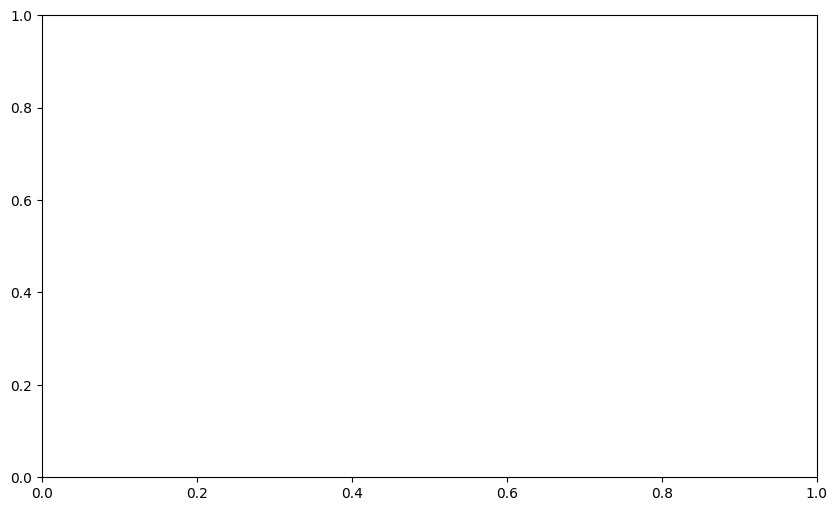

In [7]:
trainer.train()

In [8]:
import os

folder = 'models/'
os.makedirs(folder, exist_ok=True)
torch.save(student_model.state_dict(), os.path.join(folder, 'qkv_center_inhibitor1_init.pth'))

In [9]:
import matplotlib.pyplot as plt
import numpy as np

def smooth_data(data, window_size):
    cumsum = np.cumsum(np.insert(data, 0, 0)) 
    return (cumsum[window_size:] - cumsum[:-window_size]) / window_size

def organize_data_by_layer(data):
    organized_data = {}
    for entry in data:
        layer = entry['layer']
        if layer not in organized_data:
            organized_data[layer] = {'student': {'mean': [], 'max': [], 'min': []},
                                     'teacher': {'mean': [], 'max': [], 'min': []}}
        for model in ['student', 'teacher']:
            for stat in ['mean', 'max', 'min']:
                organized_data[layer][model][stat].append(entry[model][stat])
    return organized_data

def plot_all_layers(data, smooth_window=100):
    organized_data = organize_data_by_layer(data)
    num_layers = len(organized_data)
    
    fig, axs = plt.subplots(num_layers, 3, figsize=(20, 8 * num_layers))
    fig.suptitle('Layer Statistics Comparison (Smoothed)', fontsize=16)
    
    if num_layers == 1:
        axs = axs.reshape(1, -1)
    
    colors = {'student': 'blue', 'teacher': 'red'}
    stats = ['mean', 'max', 'min']
    
    for layer, (layer_num, layer_data) in enumerate(sorted(organized_data.items())):
        for col, stat in enumerate(stats):
            ax = axs[layer, col]
            for model in ['student', 'teacher']:
                original_data = layer_data[model][stat]
                
                # Plot original data with low alpha
                ax.plot(original_data, color=colors[model], alpha=0.3, linewidth=1)
                
                # Smooth and plot the data
                if len(original_data) > smooth_window:
                    smoothed_data = smooth_data(original_data, smooth_window)
                    ax.plot(range(smooth_window-1, len(original_data)), smoothed_data, 
                            color=colors[model], label=f'{model.capitalize()} (Smoothed)')
                else:
                    ax.plot(original_data, color=colors[model], label=model.capitalize())
            
            ax.set_title(f'Layer {layer_num} - {stat.capitalize()}', fontsize=12)
            ax.set_xlabel('Steps', fontsize=10)
            ax.set_ylabel('Value', fontsize=10)
            ax.legend(fontsize=8)
            ax.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.savefig('hiddenstates1_context_plot.png', dpi=300, bbox_inches='tight')
    plt.close(fig)

In [10]:
plot_all_layers(trainer.context_loss_stats)